In [1]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 49.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
import tensorflow as tf

In [4]:
# Step 3: Define the path to your images on Google Drive
image_dir = '/content/drive/MyDrive/CV_Dataset/Landsat_Coimbatore_2020_to_2021'  # Replace 'your-folder-name' with the name of your folder containing the images

In [5]:
# Step 4: Function to read NDVI data from a GeoTIFF file
def read_ndvi(file_path):
    with rasterio.open(file_path) as src:
        ndvi = src.read(1)  # Read the first band
    return ndvi


In [6]:
# Step 5: Load images from Google Drive
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.tif')]
ndvi_images = [read_ndvi(f) for f in image_files]

In [7]:
image_files

['/content/drive/MyDrive/CV_Dataset/Landsat_Coimbatore_2020_to_2021/NDVI_Coimbatore_20201027_20201226.tif',
 '/content/drive/MyDrive/CV_Dataset/Landsat_Coimbatore_2020_to_2021/NDVI_Coimbatore_20200101_20200301.tif',
 '/content/drive/MyDrive/CV_Dataset/Landsat_Coimbatore_2020_to_2021/NDVI_Coimbatore_20200301_20200430.tif',
 '/content/drive/MyDrive/CV_Dataset/Landsat_Coimbatore_2020_to_2021/NDVI_Coimbatore_20200430_20200629.tif',
 '/content/drive/MyDrive/CV_Dataset/Landsat_Coimbatore_2020_to_2021/NDVI_Coimbatore_20200629_20200828.tif',
 '/content/drive/MyDrive/CV_Dataset/Landsat_Coimbatore_2020_to_2021/NDVI_Coimbatore_20200828_20201027.tif',
 '/content/drive/MyDrive/CV_Dataset/Landsat_Coimbatore_2020_to_2021/NDVI_Coimbatore_20201226_20210224.tif',
 '/content/drive/MyDrive/CV_Dataset/Landsat_Coimbatore_2020_to_2021/NDVI_Coimbatore_Composite_Image_for_whole_year.tif']

In [8]:
# Step 6: Load VGG16 model pre-trained on ImageNet
vgg_model = VGG16(weights='imagenet', include_top=False)


58889256/58889256 [==============================] - 1s 0us/step


In [9]:
def extract_features(image):
    image_expanded = np.expand_dims(image, axis=-1)  # Add channel dimension
    image_3channel = np.repeat(image_expanded, 3, axis=-1)  # Repeat the single channel to get a 3-channel image
    image_resized = tf.image.resize(image_3channel, (224, 224))  # Resize image to VGG16 input size
    image_array = img_to_array(image_resized.numpy().copy())  # Convert tensor to numpy array and make a copy
    image_array = preprocess_input(image_array)
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
    features = vgg_model.predict(image_array)
    return features.flatten()

In [10]:
# Step 8: Extract features from all images
features = np.array([extract_features(img) for img in ndvi_images])

1/1 [==============================] - 0s 19ms/step


In [11]:
# Step 9: Apply K-Means clustering on extracted features
n_clusters = 5  # Number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(features)
labels = kmeans.labels_
silhouette_avg = silhouette_score(features, labels)

print("Silhouette Score:", silhouette_avg)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.15664394


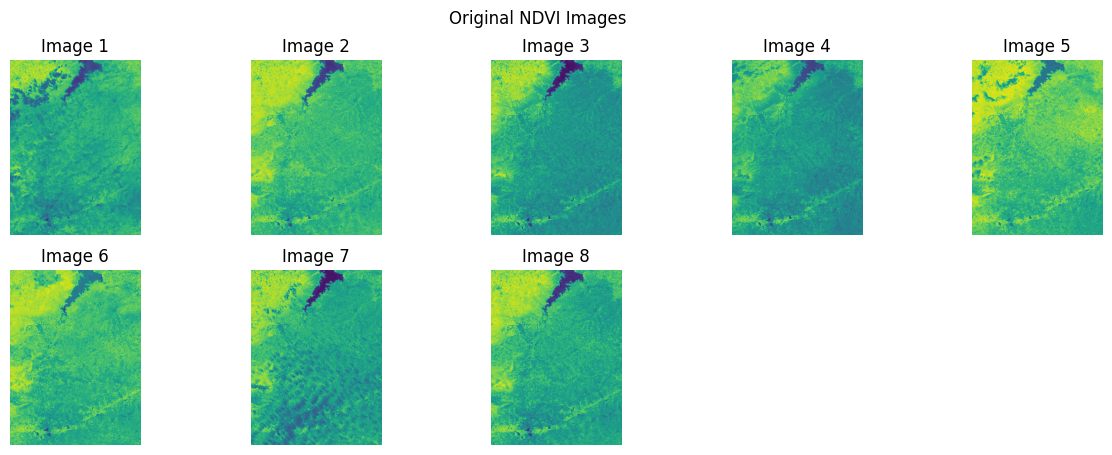

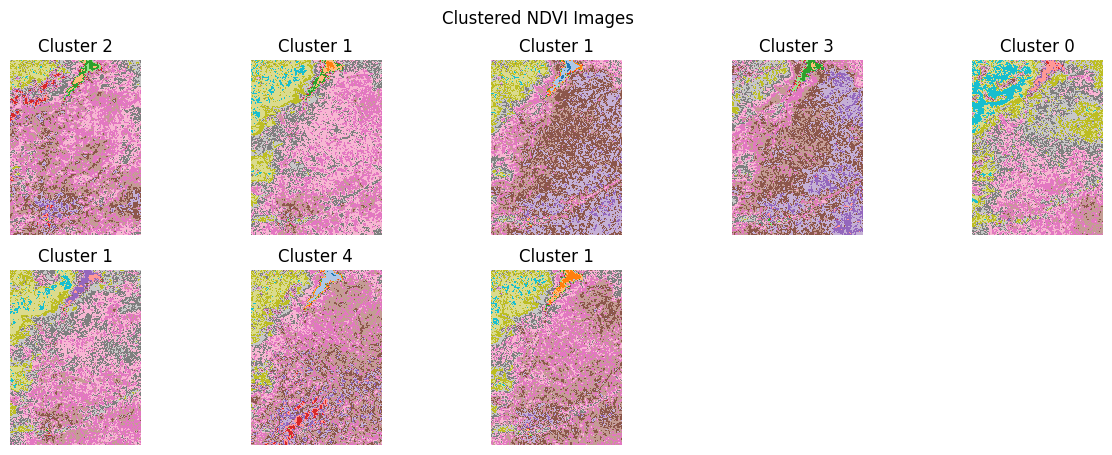

In [12]:
# Visualize Original NDVI Images
plt.figure(figsize=(15, 5))
for i, img in enumerate(ndvi_images):
    plt.subplot(2, 5, i+1)
    plt.title(f'Image {i+1}')
    plt.imshow(img, cmap='viridis')
    plt.axis('off')
plt.suptitle('Original NDVI Images')
plt.show()

# Visualize Clustered Images
plt.figure(figsize=(15, 5))
for i, img in enumerate(ndvi_images):
    plt.subplot(2, 5, i+1)
    plt.title(f'Cluster {labels[i]}')
    plt.imshow(img, cmap='tab20')
    plt.axis('off')
plt.suptitle('Clustered NDVI Images')
plt.show()

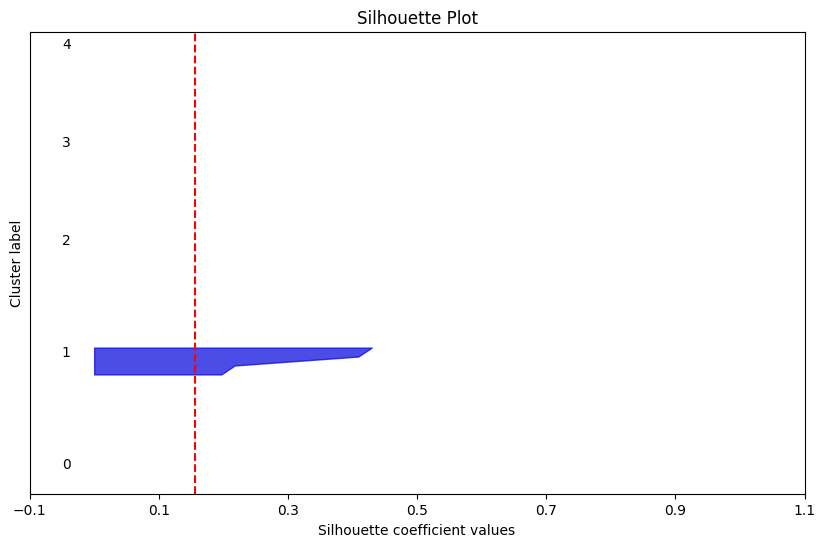

In [15]:


# Silhouette Plot
sample_silhouette_values = silhouette_samples(features, labels)

fig, ax1 = plt.subplots(figsize=(10, 6))

y_lower = 10
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10  # 10 for the 0 samples gap

ax1.set_title("Silhouette Plot")
ax1.set_xlabel("Silhouette coefficient values")
ax1.set_ylabel("Cluster label")

ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the y-axis labels / ticks
ax1.set_xticks(np.arange(-0.1, 1.1, 0.2))

plt.show()